# Bayesian Logit RESCAL 

In this notebook, I'll compare the performance of Bayesian Logistic RESCAL and Bayesian RESCAL with toy dataset.
The dataset will be generated by following the assumption of Bayesian Logistic RESCAL, which means

* Latent feature of entity $e_i \in \mathbb{R}^D$ is drawn from isotropic normal distribution.
* Latent feature of relation $R_k \in \mathbb{R}^{D\times D}$ is also drawn from isotropic normal distribution.
* The probability of triple $x_{ikj}=1$ is equal to $\sigma(1 + \exp(e_i^\top R_k e_j))$


In [1]:
color = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(color)):    
    r, g, b = color[i]    
    color[i] = (r / 255., g / 255., b / 255.)

In [2]:
import pickle
import itertools
import numpy as np
from almc.bayesian_rescal import PFBayesianLogitRescal
from almc.bayesian_rescal import PFBayesianRescal
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing as mp

%matplotlib inline

n_dim = 5
n_relation = 10
n_entity = 10
n_particle = 10
n_test = 10
total = n_relation * n_entity**2

E = np.random.normal(0, 10.0, size = [n_entity, n_dim])
R = np.random.normal(0, 10.0, size = [n_relation, n_dim, n_dim])

X = np.zeros([n_relation, n_entity, n_entity])
for k, i, j in itertools.product(range(n_relation), range(n_entity), range(n_entity)):
    x = np.dot(np.dot(E[i].T, R[k]), E[j])
    p = 1. / (1. + np.exp(-x))
    X[k, i, j] = np.random.binomial(1, p)

logit_gain = np.zeros([n_test, total])
normal_gain = np.zeros([n_test, total])

/Users/arongdari/.python3/lib/python3.4/site-packages/ipykernel/__main__.py:25: RuntimeWarning: overflow encountered in exp


In [36]:
pool = mp.Pool(8)

true_sum = np.sum(X)

for nt in range(n_test):
    def finalize(nt):
        # function argument closure
        def inner(rval):
            regret = np.zeros(total)
            cnt = 0
            for i, s in enumerate(rval):
                cnt += X[s]
                if cnt >= true_sum:
                    regret[i] = 0
                else:
                    regret[i] = 1 - X[s]
                
            logit_gain[nt] = np.cumsum(regret)
        return inner
    _callback = finalize(nt)
    model = PFBayesianLogitRescal(n_dim, n_particles=n_particle)
#     seq = model.fit(X, np.zeros_like(X), max_iter=total)
#     _callback(seq)
    pool.apply_async(model.fit, args=(X, np.zeros_like(X), total,), callback=_callback)

In [37]:
for nt in range(n_test):
    def finalize(nt):
        # function argument closure
        def inner(rval):
            regret = np.zeros(total)
            cnt = 0
            for i, s in enumerate(rval):
                cnt += X[s]
                if cnt >= true_sum:
                    regret[i] = 0
                else:
                    regret[i] = 1 - X[s]
                
            normal_gain[nt] = np.cumsum(regret)
        return inner
    _callback = finalize(nt)
    model = PFBayesianRescal(n_dim, n_particles=n_particle, compute_score=False)
#     seq = model.fit(X, np.zeros_like(X), max_iter=total)
#     _callback(seq)    
    
    pool.apply_async(model.fit, args=(X, np.zeros_like(X), total, ), callback=_callback)
pool.close()
pool.join()    

pickle.dump([normal_gain, logit_gain], open('../result/toy_logit_vs_normal/toy_logit_vs_normal_%d_%d_%d.pkl' % (n_entity,n_relation,n_dim), 'wb'))

### Plot Cumulative Gain

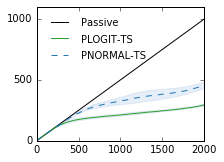

In [6]:
n_dim = 5
n_relation = 10
n_entity = 20

total = n_relation * n_entity**2

normal_gain, logit_gain = pickle.load(open('../result/toy_logit_vs_normal/toy_logit_vs_normal_%d_%d_%d.pkl' % (n_entity,n_relation,n_dim), 'rb'))

plt.figure(figsize=(3,2.4))

ratio = (total-np.sum(X))/np.prod(X.shape)
if n_entity = 10:
    ratio = 295/600
elif n_entity = 20:
    ratio = 999/2000
plt.plot(np.cumsum([ratio for i in range(total)]), label='Passive', c='k')
plt.plot(np.mean(logit_gain, 0), label='PLOGIT-TS', c=color[4])
plt.fill_between(range(total), np.mean(logit_gain, 0)-np.std(logit_gain, 0), np.mean(logit_gain, 0)+np.std(logit_gain, 0), alpha=0.3, color=color[1])
    
plt.plot(np.mean(normal_gain, 0), '--', label='PNORMAL-TS', c=color[0])
plt.fill_between(range(total), np.mean(normal_gain, 0)-np.std(normal_gain, 0), np.mean(normal_gain, 0)+np.std(normal_gain, 0), alpha=0.3, color=color[1])

#plt.axhline(y=np.sum(X), xmin=0, xmax=total, c='r')
plt.legend(loc='upper left', frameon=False)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='10')
if n_entity == 10:
    plt.xlim((0,600))
    plt.ylim((0,320))
elif n_entity == 20:
    plt.xlim((0,2000))
    plt.ylim((0,1100))
plt.locator_params(axis = 'y', nbins = 5)
plt.savefig('../paper/cikm2016/images/toy_logit_vs_normal_%d_%d_%d.pdf' % (n_entity,n_relation,n_dim), format='PDF', bbox_inches='tight', pad_inches=0.1)    
plt.show()